# WGBS analysis using MPI
In this notebook we are going to use `bigmpi4py` with a biological example to see how parallelization improves
computation times. For the biological example we will use WGBS samples from several organs/tissues from ENCODE, and we will determine methylation sites that determine variability and stability on samples.

**NOTE: Due to the large files produced, Jupyter notebook can be really slow and break. If that happens, try exporting it to a .py file and run it from there**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import os
import seaborn as sns
import time
import scipy.stats
from scipy.optimize import curve_fit
from tqdm import tqdm, tqdm_notebook

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.palettes import Category10, Category20
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.stats import gaussian_kde

Load directories

In [3]:
base_dir = '/media/seth/SETH_DATA/SETH_Alex/WGBS-ENCODE/' # Change the directory to the one where you are using
h5 = base_dir + 'BED/merge_sorted.h5'
metadata = base_dir + 'BED/metadata.tsv'
dir_figs = base_dir + 'figs/'
dir_tables = base_dir + 'tables/'
pval_table = dir_tables + 'KW_pvals_sorted.csv'

## First steps: Downloading the BED files from ENCODE
These two cells will download all files from ENCODE, and will process them to create the joint matrix of all bed files.

In [ ]:
# !sudo apt install aria2 # <- UNCOMMENT TO INSTALL ARIA2C

metadata_df = pd.read_csv(metadata, sep='\t')

list_links = metadata_df['File download URL'].values
list_names = metadata_df['File accession'].values

for i in range(len(list_links)):
    link, name = list_links[i], list_names[i] + '.bed'
    print(name)
    !aria2c -d $base_dir/BED -x 16 $link
    !gunzip $base_dir/BED/$name

In [ ]:
!python $basedir/BED-preprocess.py

Load metadata dataframe and select the CpG samples. Then, each tissue is assigned its respective germ layer.

In [3]:
metadata_df = pd.read_csv(metadata, sep='\t')
metadata_df = metadata_df[metadata_df['Output type'] == 'methylation state at CpG']\
    .sort_values(by='Biosample term name')

dict_layers = {'adipose tissue': 'mesoderm',
                'adrenal gland': 'mesoderm',
                'aorta': 'mesoderm',
                'body of pancreas': 'endoderm',
                'esophagus': 'endoderm',
                'heart': 'mesoderm',
                'heart left ventricle': 'mesoderm',
                'heart right ventricle': 'mesoderm',
                'large intestine': 'endoderm',
                'lower leg skin': 'ectoderm',
                'lung': 'endoderm',
                'muscle of leg': 'mesoderm',
                'muscle of trunk': 'mesoderm',
                'ovary': 'mesoderm',
                'pancreas': 'endoderm',
                'placenta': 'trophoblast',
                'prostate gland': 'endoderm',
                'psoas muscle': 'mesoderm',
                'right cardiac atrium': 'mesoderm',
                'sigmoid colon': 'endoderm',
                'small intestine': 'endoderm',
                'spinal cord': 'ectoderm',
                'spleen': 'mesoderm',
                'stomach': 'endoderm',
                'testis': 'mesoderm',
                'thymus': 'endoderm',
                'thyroid gland': 'endoderm',
                'tibial nerve': 'ectoderm',
                'upper lobe of left lung': 'endoderm'}

metadata_df['Germ layer'] = [dict_layers[i] for i in metadata_df['Biosample term name']]
metadata_df.to_csv(metadata, index=None, sep='\t')

Load h5 file and sort the columns to match the `accession list` dataset

Sort WGBS_df by rows and cols, and save again. **DO NOT RUN IF ALREADY SORTED!**

For the sake of simplicity, we will also remove the placenta from the samples

In [ ]:
WGBS_df = pd.read_hdf(h5, key='table')

In [ ]:
accession_list = metadata_df['File accession'][~metadata_df['Biosample term name'].isin(['placenta', 'spinal cord'])].values
accession_endo = [i for i in metadata_df['File accession'][metadata_df['Germ layer'] == 'endoderm'].values
                    if i in WGBS_df.columns.values]
accession_meso = [i for i in metadata_df['File accession'][metadata_df['Germ layer'] == 'mesoderm'].values
                    if i in WGBS_df.columns.values]
accession_ecto = [i for i in metadata_df['File accession'][metadata_df['Germ layer'] == 'ectoderm'].values
                    if i in WGBS_df.columns.values]

In [ ]:
WGBS_df = WGBS_df.sort_values(by=['chr', 'pos'])
WGBS_df = WGBS_df[['chr', 'pos'] + [i for i in accession_list if i in WGBS_df.columns.values]]
WGBS_df.to_hdf(h5, key='table')

**RUN THIS INSTEAD**

In [4]:
WGBS_df = pd.read_hdf(h5, key='table')
WGBS_arr = WGBS_df.iloc[:,2:].values

Now we will extract the features based on the germ layer. In order to do that, we will simply do a Kruskal-Wallis test
to see which features separate the germ layers best. These features can, in turn, be further selected to
divide individual tissues, if necessary.
For this part we have created a python script which calls BigMPI4py. In this part we will do a simple run with ~30 CPUs, and continue the analysis.

In [ ]:
dir_KW = base_dir + '/parallel_KW.py'
cpu = 30
mpirun -np {cpu} python {dir_KW} --h5 {h5} \
--metadata {metadata} --pval_table {pval_table}

In [5]:
list_pvals = np.loadtxt(pval_table)

# Obtaining the most differentially methylated positions

We will select the top significant rows. For simplicity of visualization we will select a really small p-value, although it can be bigger if we want more regions. We will get around 5-15k rows for each germ layer, which will allow us to see trends and do some interesting plots later on.

In [6]:
array_dim = WGBS_df.iloc[np.argwhere([list_pvals <= 0.000002])[:,1],2:]
WGBS_df_pos = WGBS_df.iloc[np.argwhere([list_pvals <= 0.000002])[:,1],:2]

In [7]:
WGBS_df_pos

chr       pos
1744      chr1     71678
2380      chr1    120037
3287      chr1    148043
5169      chr1    205332
5950      chr1    353863
...        ...       ...
58298477  chrY  56679172
58300977  chrY  56723164
58300979  chrY  56723194
58300981  chrY  56723209
58301389  chrY  56730370

[27788 rows x 2 columns]

We will plot the cells and genes with reduced dimensions to see the characteristics of the data. In order to do that, we will use scanpy, which implements functions for dimensionality reduction and clustering.

In [ ]:
dict_ac_layer = dict(zip(metadata_df['File accession'].values.tolist(), metadata_df['Germ layer']))
c_dict = {'mesoderm': 0, 'endoderm': 1, 'ectoderm': 2}

Afterwards, we will plot the cells, using the germ layer notation, as well as the leiden clustering algorithm to see similarities on the data.

In [ ]:
adata_cells = sc.AnnData(X=array_dim.values.transpose())
adata_cells.obs['Germ Layer'] = [dict_ac_layer[i] for i in WGBS_df.columns.values.tolist()[2:]]
sc.pp.pca(adata_cells)
sc.pp.neighbors(adata_cells)
sc.tl.umap(adata_cells)
sc.tl.leiden(adata_cells, resolution=1.3)
adata_cells.uns['Germ Layer_colors'] = ['#2ca02c', '#ff7f0e', '#1f77b4'] 
# Change colors to map the labels in heatmap
sc.pl.umap(adata_cells, color=['Germ Layer', 'leiden'])
plt.savefig(dir_figs+'/adata_cells.png', dpi=400)

We see that, with the exception of 3 or 4 points, most of leiden clusters co-cluster with the germ layers. Interestingly `adipose tissue`, belonging to `mesoderm` layer, appears near `endoderm` cluster. This might be an issue of sampling, or maybe a simple outlier due to its transcriptome.

We will repeat the same with the methylation sites. For this part we will only keep the clustering information.

In [ ]:
adata_genes = sc.AnnData(X=array_dim.values)
sc.pp.pca(adata_genes)
sc.pp.neighbors(adata_genes)
sc.tl.tsne(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, resolution=0.1)
adata_genes.uns['leiden_colors'] = Category20[20]
fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
sc.pl.umap(adata_genes, color=['leiden'], ax=ax2)
plt.savefig(dir_figs+'/adata_genes.png', dpi=400)

There are many clusters, but the far most important ones are 0, 1 and 2, which belong to the points specific to the germ layers, as we will see later. The rest of clusters belong to samples from the `endoderm` cluster, which might be individual samples within the tissue, or combination of samples.

The next step is to do a clustermap with genes and cells, and use the information above to see clusters. We have chosen cosine metric and average linkage because it produces the most aesthetic result. However the rest of combinations show the same trend on data.

In [ ]:
clustermap_mat = array_dim.copy()
dict_sample_tissue = dict(zip(metadata_df['File accession'].values.tolist(), metadata_df['Biosample term name'].values.tolist()))
clustermap_mat.columns = [dict_sample_tissue[i] for i in array_dim.columns]

metric, method = 'cosine', 'average'
fig = plt.figure()
labels = [int(i) for i in adata_genes.obs['leiden'].values.tolist()]
g = sns.clustermap(clustermap_mat.iloc[np.argsort(labels),:], metric=metric, method=method, row_cluster=None,
                   col_colors=[Category10[10][c_dict[i]] for i in adata_cells.obs['Germ Layer'].values],
                   row_colors=[Category20[20][i] if i < 20 else '#202020' for i in np.sort(labels)],
               yticklabels=False, xticklabels = 1, cmap='Blues_r')
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', size=7)
plt.savefig(dir_figs+'/heatmap_%s_%s_only_col.png' %(metric, method), dpi=400)

We see that the clusters from UMAPs are the same appearing at the rows of the hierarchical clustering. The same happens with the cell types and the rows of the hierarchical clustering. We see that the dark blue cluster represents highly methylated positions in ectoderm and mesoderm, some cell types in endoderm with mid methylation and others with low methylation. The light blue cluster represents cells types in endoderm with high methylation, and cells from ectodern and mesoderm with mid and low methylation. The last set of clusters, although we will only focus on the orange one, represent cells from ectoderm with high methylation values, and the rest of cells with no methylation.

# Distribution of least differentially expressed positions

We will apply the same strategy as before, but this time looking at positions whose Kruskal-Wallis p-value is highest. In this case, we will exclude p-values equal to 1 because they represent positions with no methylation in none of samples and are > 1M. We could include them in part of the analysis, but prefer to get methylation points with p-value < 1 to see heterogeneity within tissues.

For this case we will only do the heatmap, and we should expect a thorough mixing of tissues from different germ layers just at random.

In [ ]:
array_p1 = WGBS_df.iloc[np.argwhere([(list_pvals >= 0.9999) & (list_pvals < 1)])[:,1],2:]

clustermap_mat = array_p1.copy()
dict_sample_tissue = dict(zip(metadata_df['File accession'].values.tolist(), metadata_df['Biosample term name'].values.tolist()))
clustermap_mat.columns = [dict_sample_tissue[i] for i in array_dim.columns]

metric, method = 'cosine', 'average'
fig = plt.figure()
g = sns.clustermap(clustermap_mat.iloc[np.argsort(np.median(clustermap_mat, axis=1)),:], 
                   metric=metric, method=method, row_cluster=None,
                   col_colors=[Category10[10][c_dict[i]] for i in adata_cells.obs['Germ Layer'].values],
               yticklabels=False, xticklabels = 1, cmap='Blues_r')
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', size=7)
plt.savefig(dir_figs+'/heatmap_p_1.png', dpi=400)

Having seen that, we are also interested in finding, given the median methylation of all methylation positions across tisues, how many positions lay within a bin of expression. This will allow us to see the distribution of median values. We expect many methylation sites to have either a low or a high median methylation.

In [ ]:
N = 95

linsp = np.linspace(0,100,N+1)
median_list = np.median(clustermap_mat, axis=1)
median_list = median_list[np.random.randint(0, len(clustermap_mat), 1000000)]

kr_median = gaussian_kde(median_list)
kr_median.covariance_factor = lambda : .04
kr_median._compute_covariance()

plt.xlabel('Median methylation level')
plt.ylabel('Proportion')
plt.plot(linsp, kr_median(linsp))
plt.savefig(dir_figs+'/median_p_1_distribution.png', dpi=400)

# Gene analysis on differentially methylated positions

We will now obtain the genes associated to the positions represented on the heatmap.


In [ ]:
idx_mes_ect = np.argwhere(adata_genes.obs['leiden'] == '0').ravel()
idx_end = np.argwhere(adata_genes.obs['leiden'] == '1').ravel()
idx_ect = np.argwhere(adata_genes.obs['leiden'] == '2').ravel()
idx_near_1 = np.argwhere((list_pvals >= 0.999) & (list_pvals < 1)).ravel()

arr_mes_ect = array_dim.iloc[idx_mes_ect]
arr_end = array_dim.iloc[idx_end, 2:]
arr_ect = array_dim.iloc[idx_ect, 2:]
arr_near_1 = WGBS_df.iloc[idx_near_1, 2:]

BED_mes_ect = WGBS_df_pos.iloc[idx_mes_ect]
BED_end = WGBS_df_pos.iloc[idx_end]
BED_ect = WGBS_df_pos.iloc[idx_ect]
BED_near_1 = WGBS_df.iloc[idx_near_1,:2]
BED_all = WGBS_df.iloc[:,:2]

for df in [BED_mes_ect, BED_end, BED_ect, BED_near_1, BED_all]:
    df['end'] = df['pos'] + 1
    df['name'] = ['feat_%s' %i for i in range(len(df))]
    # Values already sorted by chr and pos

BED_mes_ect.to_csv(dir_tables + '/BED_ect+mes.txt', index=None, header=None, sep='\t')
BED_end.to_csv(dir_tables + '/BED_end.txt', index=None, header=None, sep='\t')
BED_ect.to_csv(dir_tables + '/BED_ect.txt', index=None, header=None, sep='\t')
BED_near_1.to_csv(dir_tables + '/BED_pval_near1.txt', index=None, header=None, sep='\t')
BED_all.to_csv(dir_tables+'/BED_all.txt', sep='\t', index=None, header=None)

This will output some BED files. The next step is to cross these BED files with a gene annotation file to see which genes overlap or are near to those methylation sites. BED file was downloaded from UCSC Table Browser (https://genome.ucsc.edu/cgi-bin/hgTables) by setting `Genes and Gene Predictions` group in `knownCanonical` table. Then, in output format select `select fields from primary and related tables`; and choose `geneSymbol`. This will also output a BED4 file (`BED_genes.txt`) which will be used for the analysis. The file may contain a line with #, which has to be removed.

We will also need, for the next step, `bedtools`. We will first sort all BED files, and then we will do the overlapping of annotation and methylation bed files.

Now we will sort and add the information about the closest genes / distance to closest gene.

In [ ]:
!bedtools sort -i $dir_tables/BED_genes.txt > $dir_tables/BED_genes_sorted.txt

In [ ]:
!bedtools closest -a $dir_tables/BED_ect+mes.txt -b $dir_tables/BED_genes_sorted.txt -d > $dir_tables/BED_ect+mes_closest_gene.txt
!bedtools closest -a $dir_tables/BED_ect.txt -b $dir_tables/BED_genes_sorted.txt -d > $dir_tables/BED_ect_closest_gene.txt
!bedtools closest -a $dir_tables/BED_end.txt -b $dir_tables/BED_genes_sorted.txt -d > $dir_tables/BED_end_closest_gene.txt
!bedtools closest -a $dir_tables/BED_pval_near1.txt -b $dir_tables/BED_genes_sorted.txt -d > $dir_tables/BED_pval_near1_closest_gene.txt
!bedtools closest -a $dir_tables/BED_all.txt -b $dir_tables/BED_genes_sorted.txt -d > $dir_tables/BED_all_closest_gene.txt

In [ ]:
BED_mes_ect_closest = pd.read_csv(dir_tables + '/BED_ect+mes_closest_gene.txt', sep='\t', header=None)
BED_ect_closest = pd.read_csv(dir_tables + '/BED_ect_closest_gene.txt', sep='\t', header=None)
BED_end_closest = pd.read_csv(dir_tables + '/BED_end_closest_gene.txt', sep='\t', header=None)
BED_near_1_closest = pd.read_csv(dir_tables + '/BED_pval_near1_closest_gene.txt', sep='\t', header=None, index_col=None)
BED_all_closest = pd.read_csv(dir_tables + '/BED_all_closest_gene.txt', sep='\t', header=None, index_col=None)

The first analysis will be to plot the distance between the methylation position and the nearest gene, for all cases.

In [ ]:
log_mes_ect = np.log10(BED_mes_ect_closest[8].values + 1)
log_ect = np.log10(BED_ect_closest[8].values + 1)
log_end = np.log10(BED_end_closest[8].values + 1)
log_near_1 = np.log10(BED_near_1_closest[8].values + 1)
log_all = np.log10(BED_all_closest.iloc[np.random.randint(0, 
                len(BED_all_closest), 100000),-1].values + 1)

ker_end = gaussian_kde(log_end)
ker_ect = gaussian_kde(log_ect)
ker_mes_ect = gaussian_kde(log_mes_ect)
ker_near_1 = gaussian_kde(log_near_1)
ker_all = gaussian_kde(log_all)

x = np.linspace(0, 7, 1000)

fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)

list_kers = [ker_end, ker_ect, ker_mes_ect, ker_near_1, ker_all]
list_labels = ['End', 'Ect', 'Mes+ect', 'p$\sim$1', 'all']

for i in tqdm(range(5)):
    ker, label = list_kers[i], list_labels[i]
    ker.covariance_factor = lambda : .07
    ker._compute_covariance()

    ax1.plot(x, ker(x)/max(ker(x)), label=label)

plt.legend()
ax1.set_xlabel('$log_{10}$(distance to gene)')

plt.savefig(dir_figs+'/gene_distance.png', dpi=400)

Some interesting remarks:

- Most of the methylation sites lay at zero distance (inside the gene) or at 100-10000 bases apart; but almost none of them within 10-100 bp range. 
- Curiously, ectoderm-associated methylation sites lay, appart from the common 100-10000 bases region, at 1M bp region.

We will take the most relevant genes and plot their location in the `WGBS_array`. For that, we will plot a heatmap with the three germ layers, and will select the `WGBS_array` positions within each positive gene, and surroundings (~ 5000 nt). 

In [ ]:
# This function obtains, from the genes associated to the selected regions (ECT, ECT+MES, END, P~1),
# the best genes, based on a minimum amount of methylation positions for each gene, and a maximum distance
# from the gene.

def get_gene_set(file, max_distance, min_gene_count): 
    bed = pd.read_csv(file, header=None, sep='\t')
    gene_list = bed.iloc[:,7].values
    gene_set, gene_counts = np.unique(gene_list, return_counts = True)

    bed_distances = []
    for gene in gene_set:
        meth_gene = bed[bed[7] == gene]
        bed_distances.append(np.percentile(meth_gene[8].values, 85))

    gene_subset = np.unique(gene_set[(gene_counts > min_gene_count) & 
                                     (np.array(bed_distances) < max_distance)]).ravel()

    return gene_subset

In [ ]:
# In the rows of the heatmap we will plot the distance from the gene. For easier visualization we will chose 
# 10 colors upstream and 10 downstream, and the distance will be the deciles betwen the maximum distance and 
# 0, using np.linspace. The reads locate within a gene will be plotted gray, and the locations of the interesting
# cases will be plotted black.

palette = ['#00429d', '#2854a6', '#3e67ae', '#507bb7', '#618fbf', 
           '#73a2c6', '#85b7ce', '#9acbd5', '#b1dfdb', '#cdf1e0',
           '#ffffe0', '#ffe5cc', '#ffcab9', '#ffaea5', '#fd9291', 
           '#f4777f', '#e75d6f', '#d84360', '#c52a52', '#ae1045',
           '#93003a']
palette[int((len(palette) - 1) / 2)] = '#ababab'

def get_color(palette, max_neg, max_pos, value, methylation_color='#000000'):
    assert len(palette) % 2 == 1

    mid_value = int((len(palette) - 1) / 2)
    list_per_neg = np.linspace(max_neg, 0, mid_value)
    list_per_pos = np.linspace(0, max_pos, mid_value)

    if value < -1:
        idx = np.argmin(np.abs(list_per_neg - value))
        return palette[idx]
    elif value == 0:
        return palette[mid_value]
    elif value == -1:
        return methylation_color
    else:
        idx = np.argmin(np.abs(list_per_pos - value))
        return palette[idx + mid_value]

In [ ]:
def plot_heatmap_gene(gene, gene_BED, WGBS_df, color_cols, x_labels,
                      df_case, palette, figname, extend=100000, max_extend = 1500000):
    # Select the location of start and end of gene, and start and end of the "case" methylations around
    # that gene. Add 500 to the extrema of that gene so that the methylation position is not the first / last
    # on the heatmap.
    
    df_gene = gene_BED[gene_BED['gene'] == gene].sort_values(by=['chr', 'start'])
    chr, start_gene, end_gene = df_gene.iloc[0, 0], df_gene.iloc[0, 1], df_gene.iloc[-1, 1]
    df_case_gene = df_case[df_case[7] == gene].sort_values(by=[0, 1])
    start_case, end_case = int(df_case_gene.iloc[0, 1] - 500), int(df_case_gene.iloc[-1, 1] + 500)


    # In some cases, start / end case are too far from our subject gene, making the computation really really long.
    # In these cases we have to cut down the distance from the start / end case to a maximum of 150000 bases.
    if abs(start_gene - start_case) > max_extend:
        start_case = start_gene - max_extend
    if abs(end_case - end_gene) > max_extend:
        end_case = end_gene + max_extend

    WGBS_gene = WGBS_df[(WGBS_df['chr'] == chr) & (WGBS_df['pos'] >= start_gene) & (WGBS_df['pos'] <= end_gene)]
    WGBS_5prime = WGBS_df[(WGBS_df['chr'] == chr) & (WGBS_df['pos'] >= min(start_gene - extend, start_case))
                          & (WGBS_df['pos'] <= start_gene)]
    WGBS_3prime = WGBS_df[(WGBS_df['chr'] == chr) & (WGBS_df['pos'] >= end_gene)
                          & (WGBS_df['pos'] <= max(end_gene + extend, end_case))]

    WGBS_concat = pd.concat([WGBS_5prime, WGBS_gene, WGBS_3prime]).reset_index(drop=True)

    # We will find the locations of the methylation positions with a small or high p-value, based on df_case
    sub_df = WGBS_concat[(WGBS_concat['chr'].isin(df_case_gene[0].values)) &
                         (WGBS_concat['pos'].isin(df_case_gene[1].values))]

    # Get the distances bewteen the positions in the heatmap and the gene.
    distance_rows = np.array([int(WGBS_5prime.iloc[row,1]) - start_gene for row in range(len(WGBS_5prime))] +
                          [0] * len(WGBS_gene) +
                          [int(WGBS_3prime.iloc[row,1]) - end_gene for row in range(len(WGBS_3prime))])
    
    # The positions with "case" methylation will be set as -1 to be painted black
    distance_rows[sub_df.index.values] = -1

    # We also set a maximum number of rows for two reasons: (1) is computation time, because plotting 
    # a 50K row heatmap is infeasible; and (2) because it is impossible to find a black 
    # position in such a big heatmap. In those cases we don't even plot the heatmap.
    if len(distance_rows) > 150000:
        print('The distance row matrix is too large: ', str(len(distance_rows)))
        return 0
    
    color_rows = [get_color(palette, min(-1, min(distance_rows)), 
                            max(1, max(distance_rows)), i) for i in tqdm(distance_rows)]

    # Here we will sort the clustermap to make columns from the same germ layer stay together
    order = np.argsort(color_cols)
    color_cols = color_cols[order]
    x_labels = x_labels[order]
    
    clustermap_mat = WGBS_concat.iloc[:, 2:].values
    clustermap_mat = clustermap_mat[:,order]

    g = sns.clustermap(clustermap_mat,  row_cluster=False, col_cluster=False,
                       col_colors=[Category10[10][i] for i in color_cols],
                       row_colors=color_rows,
                       yticklabels=False, xticklabels=x_labels, cmap='Blues_r')
    
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right', size=6)
    
    # In order to do the colorbar, we will set the boundaries and the colors that will be used
    mid_value = int((len(palette) - 1) / 2)
    bounds, cbar_colors = [], []

    if min(distance_rows) < -1:
        bounds += list(np.linspace(min(distance_rows), 0, mid_value-1))
        cbar_colors += palette[:mid_value]

    bounds += [0]


    if max(distance_rows) > 1:
        bounds += list(np.linspace(0, max(distance_rows), mid_value-1)) #Have only 1 zero
        cbar_colors += palette[mid_value:]

    cmap = mpl.colors.ListedColormap(cbar_colors)

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax_cbar = g.fig.add_axes([0.5, 0.8, 0.35, 0.05])
    cb = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, ticks=bounds, norm=norm, boundaries=bounds,
                                    spacing='proportional', orientation='horizontal')
    ticklabs = cb.ax.get_xticklabels()
    cb.ax.set_xticklabels(ticklabs, rotation=90, ha='right', size=7)


    plt.savefig(figname, dpi=400)

    plt.clf()
    plt.close()

In [ ]:
file_names = [dir_tables + '/BED_pval_near1_closest_gene.txt', dir_tables + '/BED_ect+mes_closest_gene.txt',
             dir_tables + '/BED_end_closest_gene.txt', dir_tables + '/BED_ect_closest_gene.txt']
df_list = [BED_near_1_closest, BED_mes_ect_closest, BED_end_closest, BED_ect_closest]

min_gene_counts = [10, 10, 10, 3]
dir_list = ['P_1', 'ECT_MES', 'END', 'ECT']

WGBS_df_cols = WGBS_df.columns.values[2:]
x_labels = np.array([metadata_df['Biosample term name'].loc[metadata_df['File accession'] == i].values[0] 
                     for i in WGBS_df_cols])

gene_BED = pd.read_csv(dir_tables + '/BED_genes_sorted.txt', names=['chr', 'start', 'end', 'gene'], sep='\t')

# We need the position of the columns to sort them alongside WGBS_array
color_cols = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1]) 


for i in range(4):
    gene_subset = get_gene_set(file_names[i], 150000, min_gene_counts[i])
    for gene in tqdm(gene_subset):
        plot_heatmap_gene(gene, gene_BED, WGBS_df, color_cols, x_labels, df_list[i], palette, 
                          dir_figs + '/gene_heatmaps/%s/%s.png' % (dir_list[i], gene),extend=5000)

## Time performance analysis

In [ ]:
trials = [1,2,3,4,5]
cpu_list = [1,2,4,8,10,15,20,25]
times_df = pd.DataFrame(columns=[1,2,3,4], index=[1,2,4,8,10,15,20,25])

In [ ]:
for cpu in reversed(cpu_list):
    for trial in trials:
        print('CPUs: %s // TRIAL: %s' %(cpu, trial))
        t = time.time()
        dir_KW = base_dir + '/py_files/parallel_KW.py'
        !mpirun -np {cpu} python {dir_KW}
        dt = time.time() - t
        times_df.loc[cpu, trial] = dt
        print(dt)
        
times_df.to_csv(dir_tables + '/Computation_all.csv')

We have annotated (manually) the last computation time given by tqdm for each CPU/trial combination, and saved the info to do a plot.

In [8]:
compt_df = pd.read_csv(dir_tables + '/Computation_times.csv', index_col='Unnamed: 0', dtype=float, sep=',', 
                       encoding='utf8')
times_df = pd.read_csv(dir_tables + '/Computation_all.csv', index_col='Unnamed: 0', dtype=float, sep=',', 
                              encoding='utf8')

The baseline times (reading the hdf file and writing the results) should be "the same".

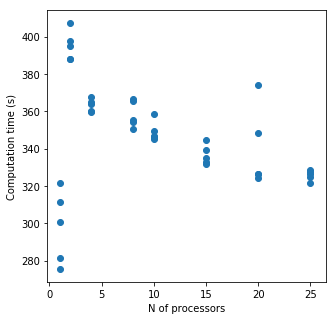

In [9]:
df_baseline = pd.DataFrame(times_df.values - compt_df.values, columns=compt_df.columns, index=compt_df.index)

fig = plt.figure(figsize=(5,5))
for row in df_baseline.index.values:
    for col in df_baseline.columns.values:
        plt.scatter(row, df_baseline.loc[row, col], c=Category20[20][0])
plt.xlabel("N of processors")
plt.ylabel("Computation time (s)")
plt.savefig(dir_figs + "/computation_base.png", dpi=500)

There is some variation in the loading times, but these are 120 s at most, which becomes irrelevant in the scale of the computation times.

[14.6433184   0.96218301] [[1.45664875e-04 4.01394972e-05]
 [4.01394972e-05 1.44682012e-05]]


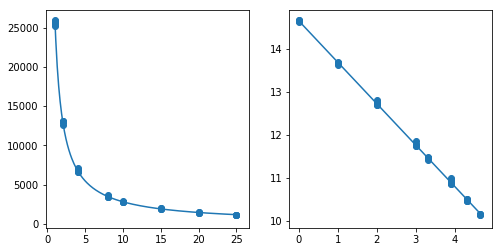

In [10]:
def f(x, b, m):
    return b - m*x

y_data = compt_df.values.ravel()
N = 5
x_data = [1]*N+ [2]*N + [4]*N + [8]*N + [10]*N + [15]*N + [20]*N + [25]*N

g = curve_fit(f, np.log2(x_data), np.log2(y_data))
print(g[0],g[1])

fig = plt.figure(figsize=(8,4))
axN = fig.add_subplot(121)
axLog = fig.add_subplot(122)
for row in compt_df.index.values:
    for col in compt_df.columns.values:
        axN.scatter(row, compt_df.loc[row, col], c=Category20[20][0])
        axLog.scatter(np.log2(row), np.log2(compt_df.loc[row, col]), c=Category20[20][0])
        
axN.plot(np.linspace(1,25,250), [2**f(np.log2(i), g[0][0], g[0][1]) for i in np.linspace(1,25,250)])
axLog.plot(np.log2(np.linspace(1,25,250)), [f(np.log2(i), g[0][0], g[0][1]) for i in np.linspace(1,25,250)])

In [11]:
slope, inter, r, p, err = scipy.stats.linregress(np.log2(x_data), np.log2(y_data))
r**2, p

(0.9994064942651297, 6.373637166453891e-63)

We see that the fit is really good, with a slope value of 0.96, denoting that the efficiency of parallelization is almost exact. R > 0.999, p < 6.37e-63

[ 1.  2.  4.  8. 10. 15. 20. 25.] ['1' '2' '3' '4' '5']


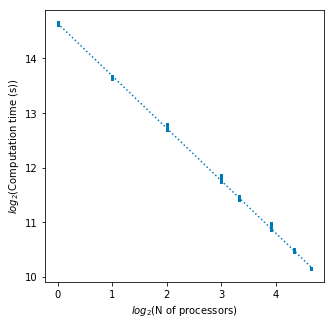

In [22]:
fig_final = plt.figure(figsize=(5,5))
plt.plot(np.log2(np.linspace(1,25,250)), [f(np.log2(i), g[0][0], g[0][1]) for i in np.linspace(1,25,250)], ':', 
         color="#007ab7", )

print(compt_df.index.values, compt_df.columns.values)
for row in compt_df.index.values:
    plt.plot([np.log2(row), np.log2(row)], [np.log2(min(compt_df.loc[row,:])), np.log2(max(compt_df.loc[row,:]))],
            color="#007ab7", linewidth=3)
#     for col in compt_df.columns.values:
#         plt.scatter(np.log2(row), np.log2(compt_df.loc[row, col]), c=Category20[20][0])
        


plt.xlabel("${log}_2$(N of processors)")
plt.ylabel("${log}_2$(Computation time (s))")
plt.savefig(dir_figs + "/computation_parallel.png", dpi=500)

In [15]:
min(compt_df.loc[row,:])

25140.0